## Figure 4. a.

In [ ]:
#TBC

## Figure 4. b.

In [1]:
# Similarity Matrix Patient
Patient = "620"

In [2]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from Full_model import Integrated_Model, Integrated_Model_RNN
import RNN as RNN

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

In [3]:
filepath = 'datasets\pat_FR_'+Patient+'.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = False)
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
dm.normalize()

--------data successfully filtered (dvariance)--------


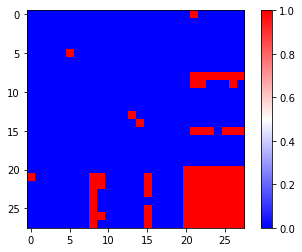

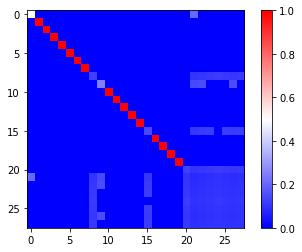

In [5]:
n = 0.1 #0.0002#0.1#1.3*10**-2
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  dm.A_train

In [6]:
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 1,
    "N": 10,
    "b_tableau": GDEsolvers.RK38
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3
}
GCNcheckpoint = {'parameters': GCNparameters}
GDEcheckpoint = {'parameters': GDEparameters}

In [7]:
A = create_DAD(Araw)
device_name = 'cpu'
GCNmodel, GCNcheckpoint = GCNutil.train_GCN(A, dm.X_train, dm.X_test, GCNcheckpoint, device_name = device_name, load = False, print_summary = False)

100%|██████████| 6/6 [00:00<00:00, 37.95it/s]

device set to cpu
Epoch: 1   Batch: 6 of size 256   Train loss: 387.6637268066406   Valid loss: 386.811309814453155


In [8]:
A = create_DAD(Araw)

device_name = 'cpu'
GDEmodel, GDEcheckpoint = GDEutil.train_GDE(A, dm.X_train, dm.X_test, GDEcheckpoint, device_name = device_name, load = False, print_summary = False)

  0%|          | 0/11 [00:00<?, ?it/s]

device set to cpu


  9%|▉         | 1/11 [00:00<00:02,  3.70it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.71it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.68it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.79it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.88it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.90it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.91it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.90it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.89it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.92it/s]

100%|██████████| 11/11 [00:02<00:00,  3.92it/s]

Epoch: 1   Batch: 11 of size 128   Train loss: 379.89910888671875   Valid loss: 378.69219970703125


In [9]:
def save_heat_map(m, DIR, cmap = 'bwr'):
    plt.clf
    fig = plt.figure()
    plt.imshow(m, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.show()
    plt.savefig(DIR)
    
def save_avg_sim_matrix(dm, sim_test, DIR):
    ictal_sum = np.zeros(sim_test[0][:,:].shape)
    normal_sum = np.zeros(sim_test[0][:,:].shape)
    tc = 0
    ni = 0
    nn = 0
    for i in range(sim_test.shape[0]):
            if dm.Y_test[tc,0] == 1:
                ictal_sum = ictal_sum + sim_test[i,:,:]
                ni+=1
            else:
                normal_sum = normal_sum + sim_test[i,:,:]
                nn+=1
            tc+=1
    ictal_sum = ictal_sum / ni
    normal_sum = normal_sum / nn
    print("Average ictal")
    save_heat_map(ictal_sum, DIR+"ictal")
    print("Average Non-Ictal")
    save_heat_map(normal_sum, DIR+"non-ictal")
    
def save_sequential_plot(dm, sim_test, DIR, i = 0):
    plt.clf
    fig, ax = plt.subplots(nrows=2, ncols=5, constrained_layout=False)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
    #plt.tight_layout()
    ictal = 0
    non_ictal = 0
    for row in ax:
        for col in row:
            im = col.imshow(sim_test[i], cmap='bwr')
            if dm.Y_test[i,0] == 1: 
                ictal+=1
                col.title.set_text("ictal {}".format(ictal))
            else:
                non_ictal += 1
                col.title.set_text("non-ictal {}".format(non_ictal))
            col.axis('off')
            i+=1

    cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(im, cax=cbar_ax)
    
    plt.savefig(DIR)
    plt.show()
    

In [10]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'
#Get simularity matrix from GCN
GCNmodel.eval()
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
#Get simularity matrix from GNODE
GDEmodel.eval()
sim_all["GDE_train"] = GDEmodel(torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_all["GDE_test"] = GDEmodel(torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

In [11]:
#save_avg_sim_matrix(dm, sim_all["GCN_test"], "Figure 4. b/GCN_2L"+Patient)
#save_avg_sim_matrix(dm, sim_all["GDE_test"], "Figure 4. b/GDE_EF"+Patient)

In [12]:
#print(dm.Y_test.tolist())
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

AttributeError: module 'MLP' has no attribute 'auc2'

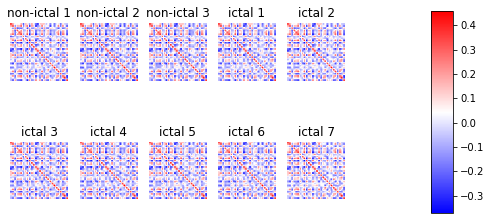

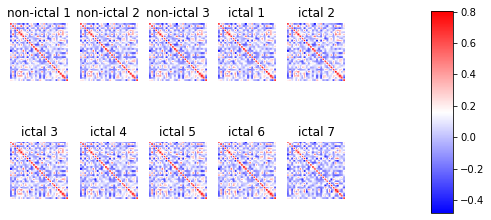

In [13]:
save_sequential_plot(dm, sim_all["GCN_test"], "Figure 4. b/GCN_1L_sequence_"+Patient, i = 4)
save_sequential_plot(dm, sim_all["GDE_test"], "Figure 4. b/GDE_RK4_sequence_"+Patient, i = 4)

## Figure 4. c.

In [14]:
#Extract Hidden State
GCNmodel.eval()
GDEmodel.eval()

ODENet(
  (f): Block()
  (tail): SimularityMatrix (62)
)

In [15]:
_, GCN_embeddings = GCNmodel.embedding_forward(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name))
for h in GCN_embeddings:
    print(h.shape)
_, GDE_embeddings = GDEmodel.embedding_forward(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name))
for h in GDE_embeddings:
    print(h.shape)

torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])


In [16]:
def show_varience(var, csvar, k):
    plt.step(range(1, len(var)+1), var)
    plt.step(range(1, len(csvar)+1), csvar)    
    plt.axvline(k)
    plt.show()

def pcaifier(arr, k = 69, verbose = True):
    """ arr: [m x n] numpy array
        percent: percent of varience to capture
     """
    cache = {}
    cache["mean"] = np.mean(arr, axis = 0)
    cache["std"] = np.std(arr)

    arr = (arr - np.mean(arr, axis = 0))/np.std(arr) # normalize
    arr_cov = np.cov(arr.T)
    eval, evec = np.linalg.eig(arr_cov)
    idx = eval.argsort()[::-1] # Sort descending and get sorted indices
    evec = evec[:,idx]
    eval = eval[idx]

    cache["eigenvalues"] = eval
    cache["eigenvectors"] = evec

    tot = sum(eval)
    var_exp = [(i/tot) for i in eval]
    cum_var_exp = np.cumsum(var_exp)
    

    if verbose:
        show_varience(var_exp, cum_var_exp, k)
        print("% kept at dimension", k, ":", cum_var_exp[k-1])
    return evec, cache



(1487, 31)


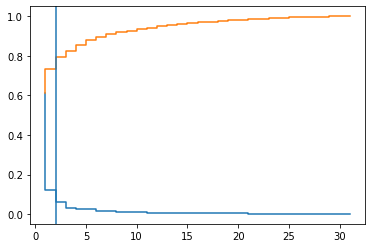

% kept at dimension 2 : 0.7313694130330444
(1487, 31)


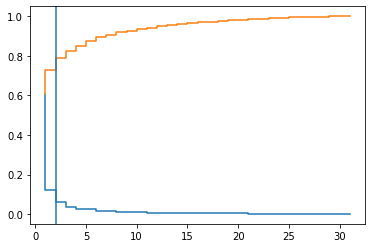

% kept at dimension 2 : 0.727415641249673
(1487, 31)


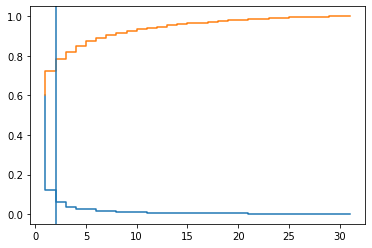

% kept at dimension 2 : 0.7233533904032444
(1487, 31)


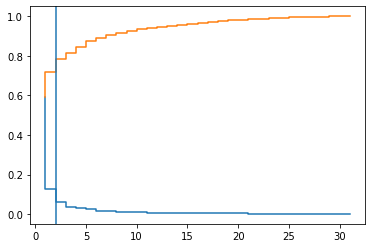

% kept at dimension 2 : 0.7191832831553359
(1487, 31)


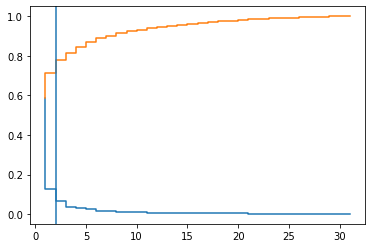

% kept at dimension 2 : 0.7149094688479684
(1487, 31)


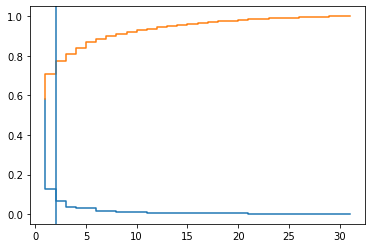

% kept at dimension 2 : 0.7105375988104463
(1487, 31)


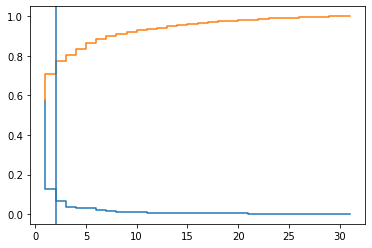

% kept at dimension 2 : 0.7060731269530232
(1487, 31)


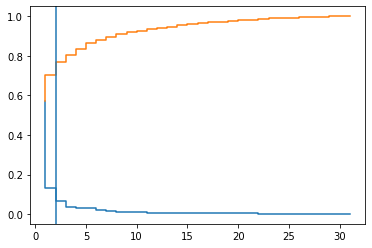

% kept at dimension 2 : 0.7015233872125407
(1487, 31)


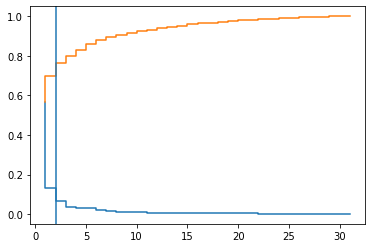

% kept at dimension 2 : 0.6968963081737873
(1487, 31)


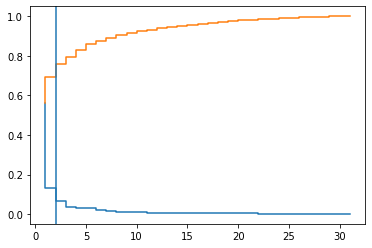

% kept at dimension 2 : 0.6922012429126144
(1487, 31)


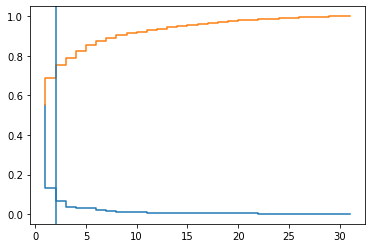

% kept at dimension 2 : 0.6874516810514986
(11, 1487, 2)


In [17]:
reduced_embeddings = np.zeros([len(GDE_embeddings), GDE_embeddings[0].shape[0], 2])
for i,h in enumerate(GDE_embeddings):
    h = h[:,0,:].cpu().detach().numpy()
    print(h.shape)
    evec, _ = pcaifier(h, k = 2, verbose = True)
    reduced_embeddings[i, :,:] = h@evec[:,:2]
    
print(reduced_embeddings.shape)

In [18]:
print(dm.Y_test[:50,:])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


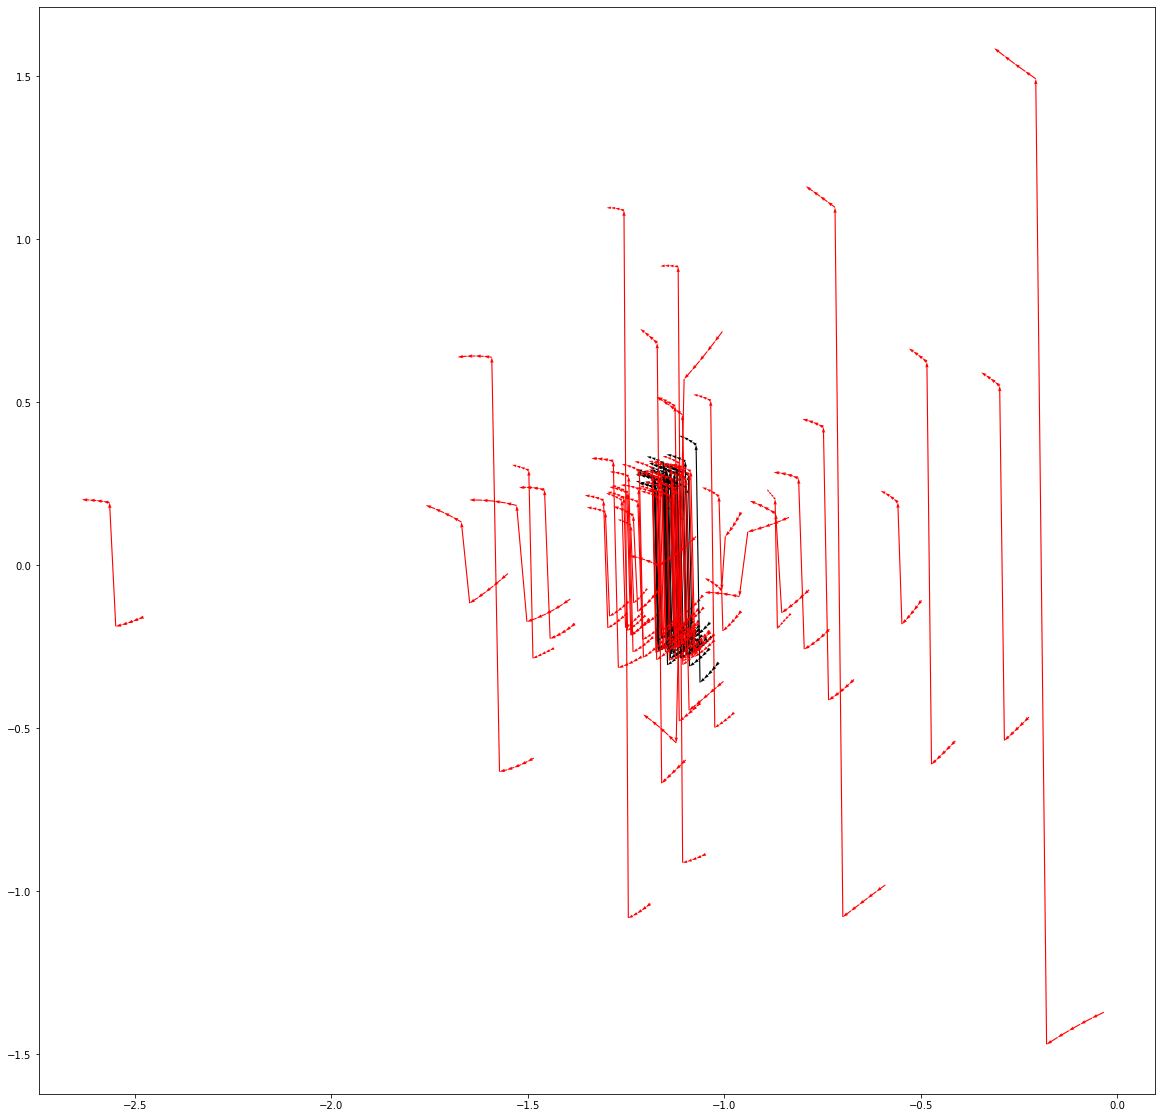

In [19]:
def plot_quiver(x, y, color = 'black'):
    plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color = color, width=0.001)
#plt.plot(reduced_embeddings[:,0,0],reduced_embeddings[:,0,1])
#plt.plot(reduced_embeddings[:,1,0],reduced_embeddings[:,0,1])
#plt.plot(reduced_embeddings[:,2,0],reduced_embeddings[:,0,1])
#plt.plot(reduced_embeddings[:,123,0],reduced_embeddings[:,0,1])
plt.figure(figsize=(20, 20))
for i in range(100):
    color = 'red' if dm.Y_test[i,0] == 1 else 'black'
    plot_quiver(reduced_embeddings[:,i,0],reduced_embeddings[:,i,1], color)
plt.show()


In [20]:
plt.clf
nrows = 30
ncols=15
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, constrained_layout=False, figsize=(ncols*10,nrows*10))
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
plt.tight_layout()
i=0
for row in ax:
    for col in row:
        x = reduced_embeddings[:,i,0]
        y = reduced_embeddings[:,i,1]
        
        if dm.Y_test[i,0] == 1: 
                col.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color = 'red')
                col.title.set_text("ictal {}".format(i))
        else:
                col.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color = 'black')
                col.title.set_text("non-ictal {}".format(i))
        i+=1
    
#plt.savefig(DIR)
plt.show()

In [291]:
#print(np.where(dm.Y_test==1))

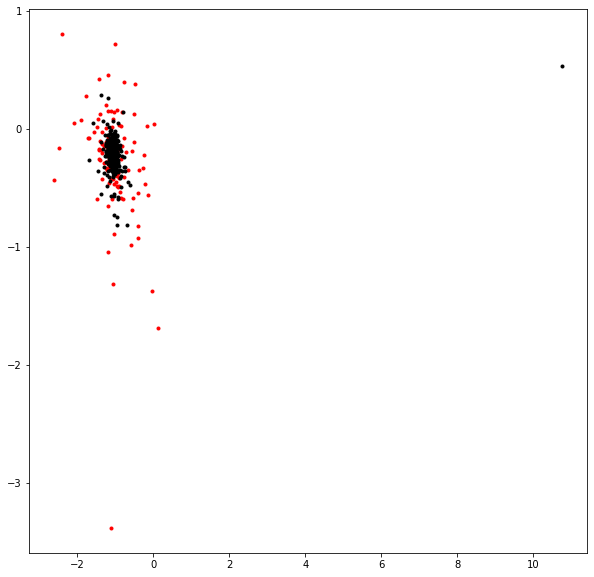

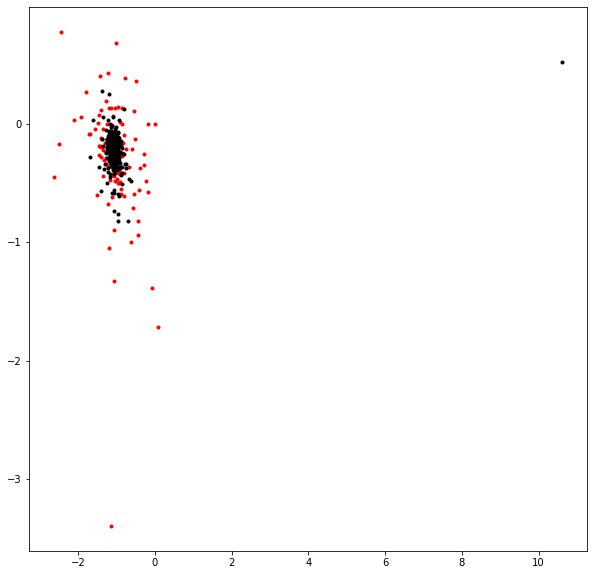

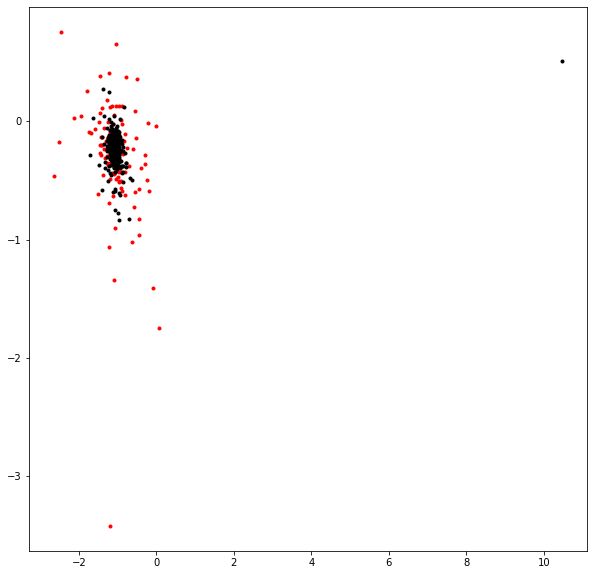

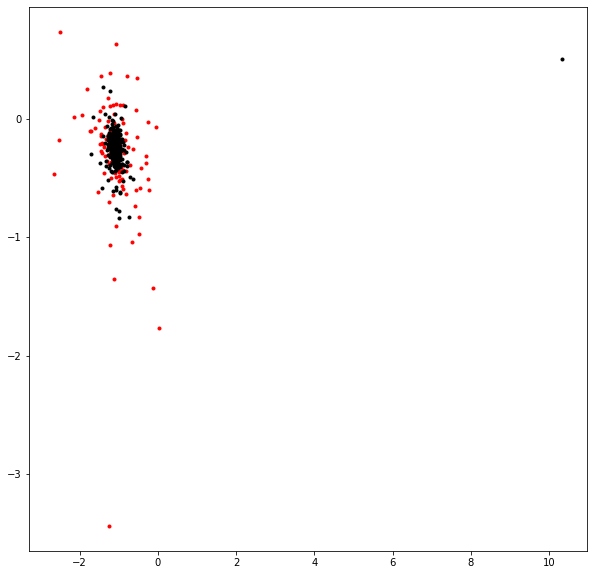

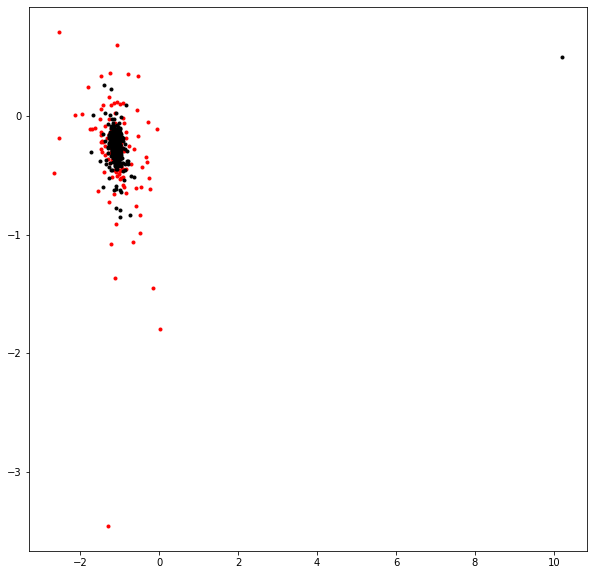

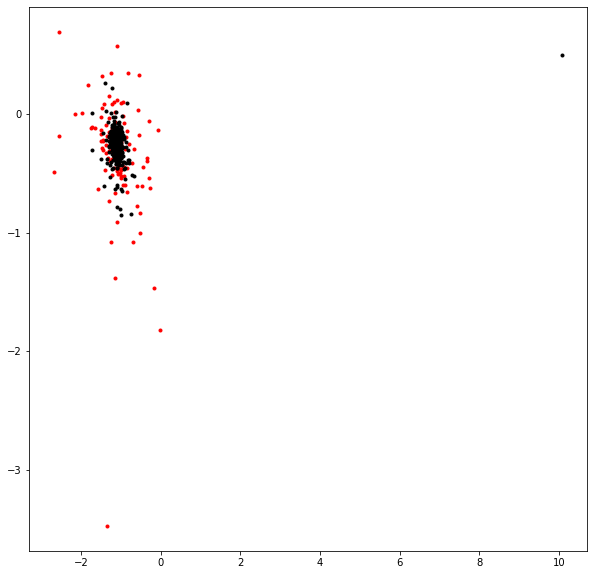

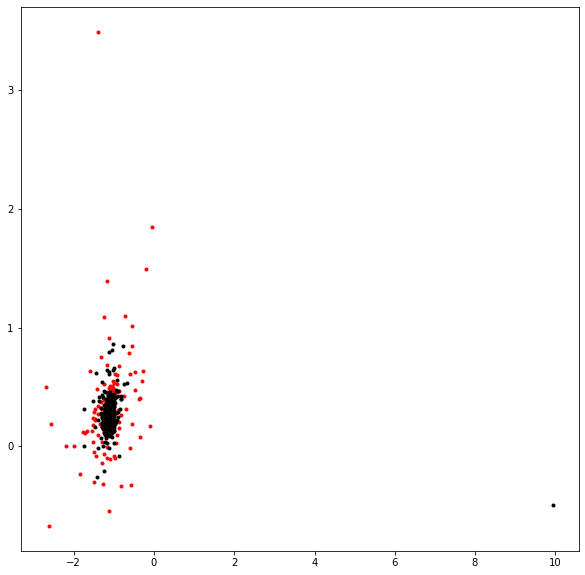

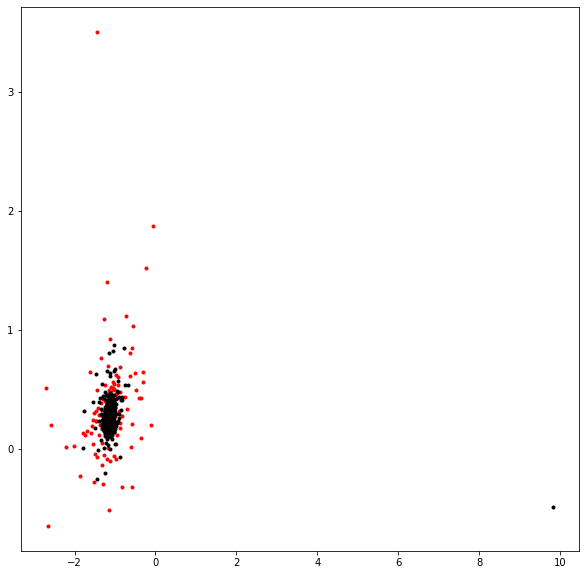

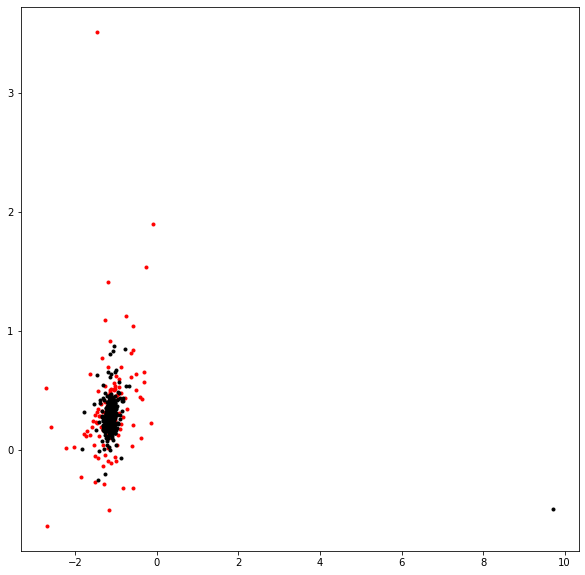

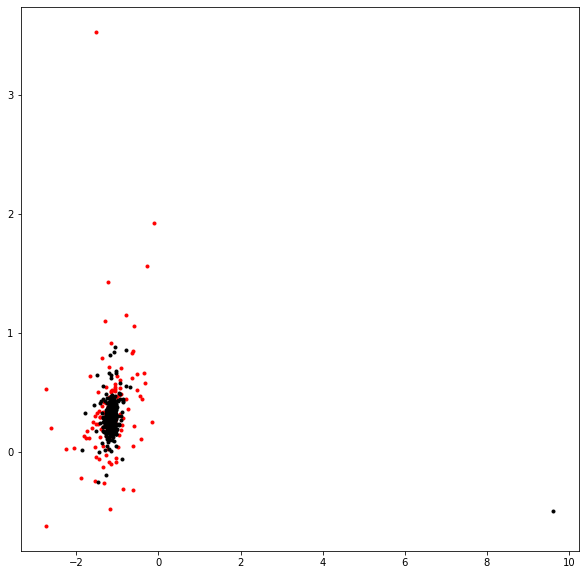

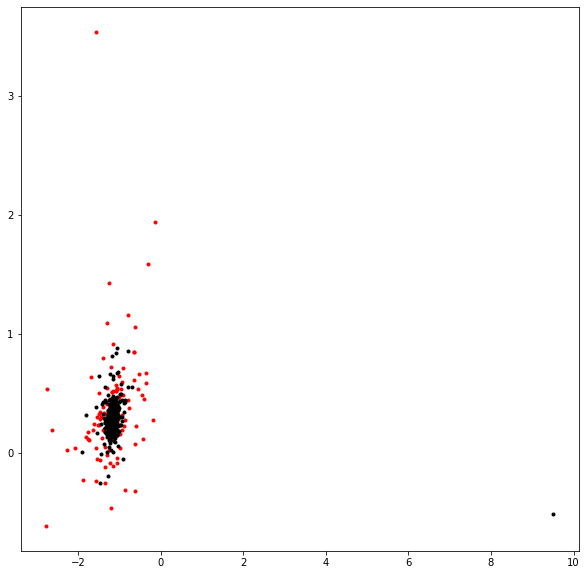

In [21]:
def plot_ictal_nonictals():
    
    ictals = reduced_embeddings[:,np.where(dm.Y_test==1)[0],:]
    nonictals = reduced_embeddings[:,np.where(dm.Y_test==0)[0],:]
    for i in range(len(reduced_embeddings)):
        plt.figure(figsize=(10, 10))
        plt.plot(ictals[i,:,0], ictals[i,:,1],  '.', color = 'red')
        plt.plot(nonictals[i,:,0], nonictals[i,:,1],  '.', color = 'black')
        plt.show()
    
plot_ictal_nonictals()

In [ ]:
#multiple nodes

In [22]:
all_node_reduced_embeddings = np.zeros([len(GDE_embeddings), GDE_embeddings[0].shape[0], GDE_embeddings[0].shape[1],2])
for i,H in enumerate(GDE_embeddings):
    for n in range(GDE_embeddings[0].shape[1]):
        h = H[:,n,:].cpu().detach().numpy()
        #print(h.shape)
        evec, _ = pcaifier(h, k = 2, verbose = False)
        all_node_reduced_embeddings[i, :,n,:] = h@evec[:,:2]
    
print(all_node_reduced_embeddings.shape)

(11, 1487, 28, 2)


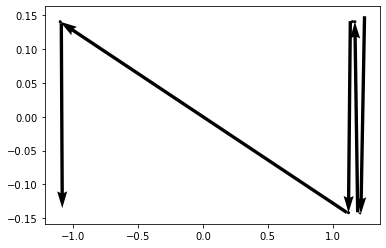

In [24]:
def plot_nodes_progression(i):
    '''
    plots nodes progression for a single node
    '''
    for n in range(2,3):#all_node_reduced_embeddings.shape[2]):
        x = all_node_reduced_embeddings[:,i,n,0]
        y = all_node_reduced_embeddings[:,i,n,1]
        plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, color = 'black', width=0.01)
    plt.show()

plot_nodes_progression(1)

## Figure 4. d.

In [13]:
#Extract Hidden States
GCNmodel.eval()
GDEmodel.eval()

ODENet(
  (f): Block()
  (tail): SimularityMatrix (62)
)

In [72]:
#plot seq
def sequential_plot(lis, names = None):#, DIR
    plt.clf
    fig, ax = plt.subplots(nrows=1, ncols=len(lis), constrained_layout=True)
    #plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
    #plt.tight_layout()
    i=0
    for col in ax:
            im = col.imshow(lis[i], cmap='bwr')
            if names is not None:
                col.title.set_text(names[i])

            col.axis('off')
            i+=1

    #cbar_ax = fig.add_axes([1.1, 0.15, 0.05, 0.7])
    fig.colorbar(im)#, cax=cbar_ax)
    
    #plt.savefig(DIR)
    plt.show()

In [73]:
_, GCN_embeddings = GCNmodel.embedding_forward(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name))
for h in GCN_embeddings:
    print(h.shape)

torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])


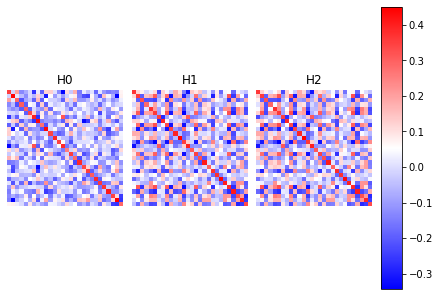

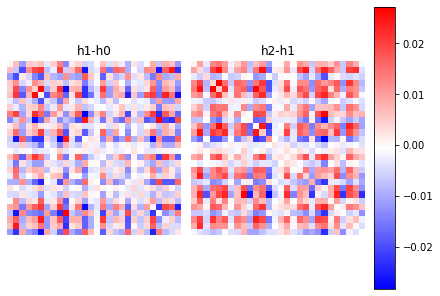

In [74]:
lis = []
for j, h in enumerate(GCN_embeddings):
    sim_m = GCNmodel.tail(h, torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()
    
    #save_avg_sim_matrix(dm, sim_m, "Figure 4. b/junk"+Patient)
    label = dm.Y_test

    sample_non_ictal = None
    sample_ictal = None

    for i in range(sim_m.shape[0]):
            if label[i,0] == 1 and sample_ictal is None:
                sample_ictal = sim_m[i,:,:]

            elif label[i,0] == 0 and sample_non_ictal is None:
                sample_non_ictal = sim_m[i,:,:]

            elif sample_ictal is not None and sample_non_ictal is not None:
                break
    #print("sample ictal")
    #show_heat_map(sample_ictal)
    #print("sample Non-Ictal")
    #print("sample Non-Ictal h", j)
    #show_heat_map(sample_non_ictal)
    
    lis.append(sample_non_ictal)

sequential_plot(lis, ['H'+str(i) for i in range(len(lis))])

dif = []
for i in range(len(GCN_embeddings)-1):
    dif.append(lis[i+1]-lis[i])  
sequential_plot(dif, ["h"+str(i+1)+"-"+"h"+str(i) for i in range(len(lis))])

In [61]:
_, GDE_embeddings = GDEmodel.embedding_forward(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name))
for h in GDE_embeddings:
    print(h.shape)

torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])
torch.Size([1487, 28, 31])


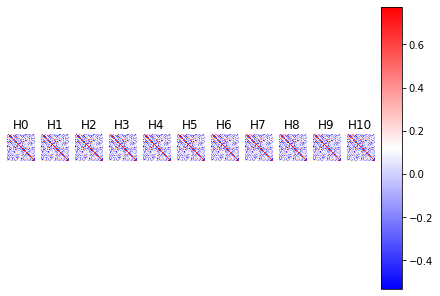

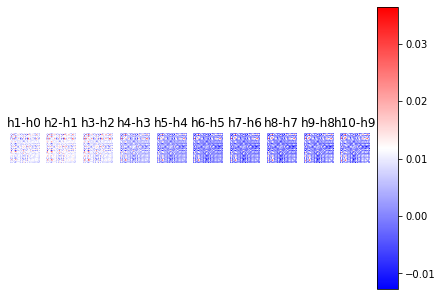

In [65]:
lis = []
for j, h in enumerate(GDE_embeddings):
    sim_m = GDEmodel.tail(h, torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()
    #save_avg_sim_matrix(dm, sim_m, "Figure 4. b/junk"+Patient)
    label = dm.Y_test

    sample_non_ictal = None
    sample_ictal = None

    for i in range(sim_m.shape[0]):
            if label[i,0] == 1 and sample_ictal is None:
                sample_ictal = sim_m[i,:,:]

            elif label[i,0] == 0 and sample_non_ictal is None:
                sample_non_ictal = sim_m[i,:,:]

            elif sample_ictal is not None and sample_non_ictal is not None:
                break
    #print("sample ictal")
    #show_heat_map(sample_ictal)
    #print("sample Non-Ictal h", j)
    #show_heat_map(sample_non_ictal)
    lis.append(sample_non_ictal)
sequential_plot(lis, ['H'+str(i) for i in range(len(lis))])

dif = []
for i in range(len(GDE_embeddings)-1):
    dif.append(lis[i+1]-lis[i])  
sequential_plot(dif, ["h"+str(i+1)+"-"+"h"+str(i) for i in range(len(lis))])

In [40]:
sim_train = GCNmodel.tail(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(X_train).float().to(device_name)).cpu().detach().numpy()
sim_test = GCNmodel.tail(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(X_test).float().to(device_name)).cpu().detach().numpy()

In [41]:
#print(dm.Y_test.tolist())

In [42]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_train, sim_test, MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
#Evaluate raw sim matrices

In [21]:
def fcn(Z):
    norm_Z = (Z - torch.mean(Z, dim=2, keepdim=True))
    return norm_Z / torch.std(Z, unbiased=True, dim=2, keepdim=True)

def get_sim_vectorized(Z):  # Z is M x N Sx 2D
    Z = fcn(Z)
    sim_matrix = torch.matmul(Z, torch.transpose(Z, 1, 2))
    return sim_matrix

sim_train = get_sim_vectorized(torch.from_numpy(dm.X_train)).numpy()
sim_test = get_sim_vectorized(torch.from_numpy(dm.X_test)).numpy()

Average ictal


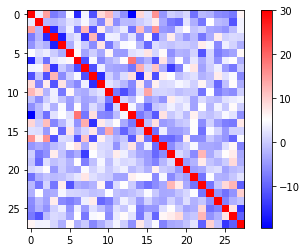

Average Non-Ictal


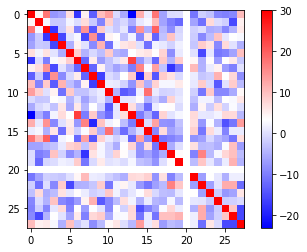

In [22]:
visualize_avg_sim_matrix(dm, sim_train, sim_test)

In [23]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_train, sim_test, MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

RuntimeError: CUDA error: device-side assert triggered

In [ ]:
#Evaluate Nafiseh's sim matrices

In [144]:
sim_train = np.load('datasets/sample_patients_embeddings/pat_FR_620_Training_Similarities.npy')
sim_test = np.load('datasets/sample_patients_embeddings/pat_FR_620_Testing_Similarities.npy')
sim_train, sim_test = GCNutil.load_flattened_sim_matrix(sim_train, sim_test, dm)
print(sim_train.shape)

(1387, 31, 31)


(1387, 1)
(1487, 1)
(1487, 31, 31)
Average ictal


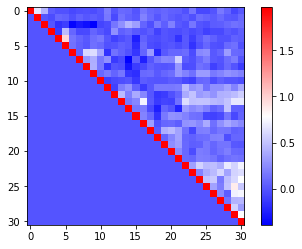

Average Non-Ictal


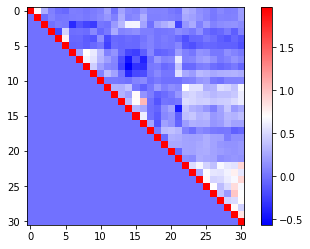

In [68]:
print(dm.Y_train.shape)
print(dm.Y_test.shape)
print(sim_test.shape)
visualize_avg_sim_matrix(dm, sim_train, sim_test)

In [69]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,1], 
    'dropout':[0.3, 0.3],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_train, sim_test, MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=496, out_features=496, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=496, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 496]               0
            Linear-2                  [-1, 496]         246,512
              ReLU-3                  [-1, 496]               0
           Dropout-4                  [-1, 496]               0
            Linear-5                    [-1, 1]             497
           Sigmoid-6                    [-1, 1]               0
Total params: 247,009
Trainable params: 247,009
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.